## Loading the data

In [1]:
%matplotlib notebook
# Change notebook to widget if you use jupyter lab

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

In [2]:
(X_train_raw, Y_train), (X_val, Y_val) = get_data_set()
X_train_raw.shape, Y_train.shape

((228,), (228,))

# Utils 

In [11]:
def evaluate_classifiers(clfs, X, Y, cv):
    f1_micro = []
    precision_micro = []
    recall_micro = []
    
    for clf in clfs:
        val_dict = cross_validate(clf, X, Y, cv=cv, scoring=['f1_micro', 'precision_micro', 'recall_micro'])
        f1_micro.append(val_dict['test_f1_micro'])
        precision_micro.append(np.mean(val_dict['test_precision_micro']))
        recall_micro.append(np.mean(val_dict['test_recall_micro']))

    return np.array(f1_micro), np.array(precision_micro), np.array(recall_micro)

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import cross_validate

In [6]:
classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), LinearSVC(max_iter=10000, tol=1e-4), DummyClassifier(strategy='uniform')]

# Color histogram feature extraction

In [7]:
X_train = np.array([cv2.medianBlur(img, 3, 0) for img in X_train_raw], dtype=object)

In [8]:
from sklearn.cluster import KMeans
from dobble_master_race.img_utils import mask_with_inner

nb_sample = 50000

def get_hist(color_map, nb_colors):
    hist = np.bincount(color_map, minlength=nb_colors)
    norm_hist = hist / hist.max()
    
    return norm_hist

def color_histograms_extraction(X, nb_colors, kmeans=None):  
    masks = np.array([mask_with_inner(img, 240) for img in X], dtype=object)
    nb_sample_per_image = nb_sample // len(X)
    
    if kmeans is None:
        sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack

        for img, mask in zip(X[1:], masks[1:]):
            pxls = img[mask]
            new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
            sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

        kmeans = KMeans(n_clusters=nb_colors, random_state=42)
        kmeans.fit(sample_pxls)
    
    color_maps = np.array([
        kmeans.predict(img[mask])
        for img, mask in zip(X, masks)
    ], dtype=object)
    
    colors_hists = np.array([get_hist(color_map, nb_colors) for color_map in color_maps])

    return colors_hists, kmeans

# Hu Moments feature extraction

In [22]:
import cv2 as cv

gray_threshold = 245

def hu_moments_compute(X):
    shape_masks = np.array([
        np.array(img.sum(axis=-1) < (gray_threshold * 3), dtype=np.uint8)
        for img in X
    ], dtype=object)

    moments = np.array([cv.moments(mask, binaryImage=True) for mask in shape_masks])
    hu_moments = np.array([cv.HuMoments(mask_moments)[:-1] for mask_moments in moments])

    return -(np.sign(hu_moments) * np.log(np.abs(hu_moments))).reshape(hu_moments.shape[:-1])

# Early fusion

We concatenate each color histogram vector with it's associated hu_moments vector 

In [10]:
def merge_histo_hu(colors_histograms, hu_moments, nb_moments):
    return np.hstack((colors_histograms, hu_moments[:,:nb_moments]))

## Classifiers based on merged features

In [12]:
def evaluate_clf_on_range(clf, nb_colors_range, moments_range, X, Y, cv):
    precisions = []
    hu_moments = hu_moments_compute(X)

    for nb_colors in nb_colors_range:
        precisions_color = []
    
        # Don't compute histogram when we have zero color to samples 
        if nb_colors:
            color_histograms, _ = color_histograms_extraction(X, nb_colors)
        else:
            color_histograms = np.zeros((len(X), 0))
    
        for nb_moments in moments_range:
            # Skip when we have a merged features vector of lenght zero
            if nb_moments + nb_colors == 0:
                precisions_color.append(np.zeros(len(classifiers)))
                continue
            merged = merge_histo_hu(color_histograms, hu_moments, nb_moments) 
            _, precision_micro, _ = evaluate_classifiers(classifiers, merged, Y, cv)

            precisions_color.append(precision_micro)

        precisions.append(np.array(precisions_color))

    return np.array(precisions)


In [14]:
precisions = evaluate_clf_on_range(classifiers, [0] + list(range(2, 20)), range(7), X_train, Y_train, 4)

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to 

In [15]:
XS, YS = np.meshgrid(range(7), [0] + list(range(2, 20)))

<IPython.core.display.Javascript object>


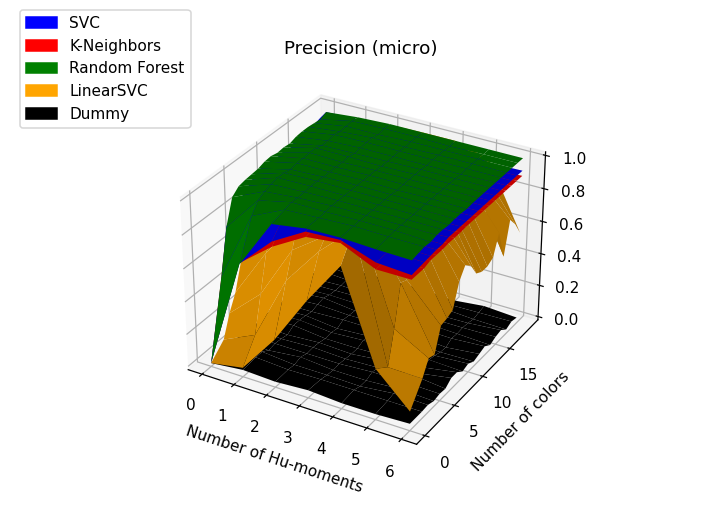

In [16]:
import matplotlib.patches as mpatches

fig = plt.figure()

color_range = [0] + list(range(2, 20))


ax = fig.add_subplot(projection='3d')

ax.set_title("Precision (micro)")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Observation

We can clearly see that the Random Forest clearly outperforms the others 4 classifiers in every combination of colors and hu-moments (ranging from 0 to 19 and from 0 to 6 respectively).
We also observe that LinearSVC, SVC and KNeighbors classifiers seem to perform better with a smaller number of hu moments (2 to 4).
Linear SVC failed to give correct results on hu-moments and colors histograms alone and has overall way worse results than the others classifiers (apart from the dummy) and even failed to converge on certains combinations (cf. ConvergeWarnings on the computation of precision).

## Improvements

As we wanted to improve our results. We started to analyse the data we fed to the classifiers and we observed impactfull differences between our Hu moments features and our colors histograms features.

In [19]:
color_histograms, _ = color_histograms_extraction(X_train, 10)

In [20]:
np.var(color_histograms,axis=0)

array([0.09845   , 0.10461741, 0.15749878, 0.11892438, 0.1134201 ,
       0.07675944, 0.12939599, 0.10679572, 0.03254577, 0.08099287])

In [23]:
np.var(hu_moments_compute(X_train_raw), axis=0)

array([9.94537856e-02, 7.26525459e+00, 7.88901873e+00, 8.39609477e+00,
       3.51988909e+02, 1.66520717e+02])

There is more variance (multiple orders of magniture) on the hu moments features than on the colors histograms. This difference could affect classifiers based on distance computation as a variation in one of the feature of the color histogram would have less impact on the distance than a variation in the hu moments.

To correct this, we needed to have a similar variance between each feature distribution of the merged feature vector. So we needed to use the StandardScaler to make sure that each feature distribution variance equals to one.

To achieve this we transform our classifiers into pipelines each composed of a StandardScaler and the original classifier.

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

classifiers = [make_pipeline(StandardScaler(), clf) for clf in classifiers]

In [25]:
classifiers

[Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('linearsvc', LinearSVC(max_iter=10000))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('dummyclassifier', DummyClassifier(strategy='uniform'))])]

In [26]:
precisions = evaluate_clf_on_range(classifiers, [0] + list(range(2, 20)), range(7), X_train, Y_train, 4)

<IPython.core.display.Javascript object>


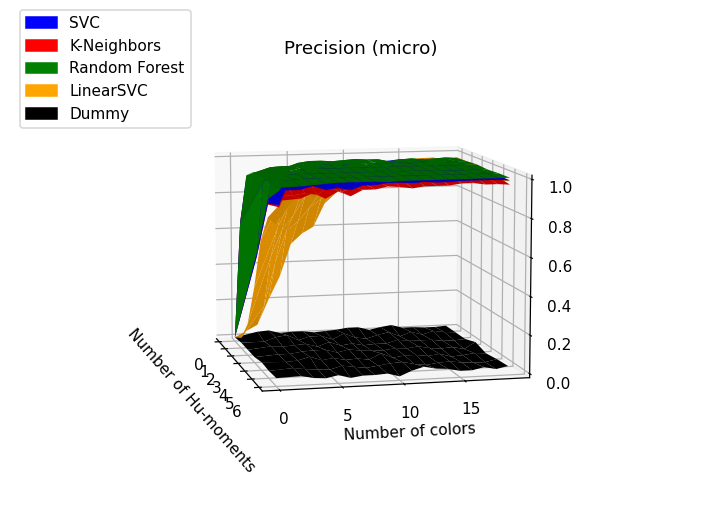

In [28]:
fig = plt.figure()

color_range = [0] + list(range(2, 20))


ax = fig.add_subplot(projection='3d')

ax.set_title("Precision (micro)")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Observation

We can see a clear improvements from the previous results on every classifiers.The Linear SVC gives now similar results to the SVC and KNeighbors classifiers on combined feature vectors of length greater than 10.

## Validation
Evaluation on the validation dataset

In [31]:
from sklearn.metrics import precision_score
from sklearn.base import clone

precisions = []
color_range = [0] + list(range(2, 20))

hu_moments_train = hu_moments_compute(X_train_raw)
hu_moments_val = hu_moments_compute(X_val)

for nb_colors in color_range:
    precisions_color = []
    
    # Don't compute histogram when we have zero color to samples 
    if nb_colors:
        color_histograms_train, kmeans = color_histograms_extraction(X_train, nb_colors)
        color_histograms_val, _ = color_histograms_extraction(X_val, nb_colors, kmeans)
    else:
        color_histograms_train = np.zeros((len(X_train), 0))
        color_histograms_val = np.zeros((len(X_val), 0))
        
    for nb_moments in range(7):
        # Skip when we have a merged features vector of lenght zero
        if nb_moments + nb_colors == 0:
            precisions_color.append(np.zeros(len(classifiers)))
            continue

        merged_train = merge_histo_hu(color_histograms_train, hu_moments_train, nb_moments)
        merged_val = merge_histo_hu(color_histograms_val, hu_moments_val, nb_moments)
        precisions_micro = []
        for clf in classifiers:
            precisions_micro.append(precision_score(Y_val, clone(clf).fit(merged_train, Y_train).predict(merged_val), average='micro'))
        precisions_color.append(precisions_micro)

    precisions.append(np.array(precisions_color))

precisions = np.array(precisions)
precisions

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.78947368, 0.77192982, 0.73684211, 0.03508772, 0.05263158],
        [1.        , 0.96491228, 0.98245614, 0.1754386 , 0.        ],
        [1.        , 1.        , 1.        , 0.40350877, 0.01754386],
        [1.        , 1.        , 1.        , 0.73684211, 0.        ],
        [0.96491228, 0.94736842, 0.98245614, 0.80701754, 0.03508772],
        [0.96491228, 0.94736842, 1.        , 0.84210526, 0.        ]],

       [[0.45614035, 0.45614035, 0.36842105, 0.0877193 , 0.        ],
        [0.85964912, 0.85964912, 0.89473684, 0.22807018, 0.        ],
        [0.98245614, 0.98245614, 0.98245614, 0.59649123, 0.        ],
        [1.        , 1.        , 1.        , 0.8245614 , 0.        ],
        [1.        , 1.        , 1.        , 0.92982456, 0.        ],
        [0.96491228, 0.98245614, 1.        , 0.94736842, 0.03508772],
        [0.96491228, 0.96491228, 1.        , 0.96491228, 0.03508772]],

       [[0.70175

<IPython.core.display.Javascript object>


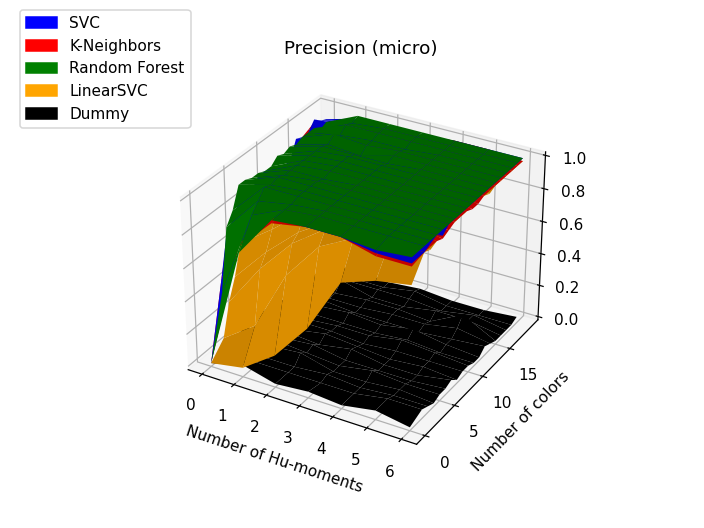

In [32]:
fig = plt.figure()

color_range = [0] + list(range(2, 20))


ax = fig.add_subplot(projection='3d')

ax.set_title("Precision (micro)")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Observation
We can observe that the classifiers perform the same as one the trainnig set, showing that there is no overfitting.